# <p><center> **PROYECTO 16** </center></p>  

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas.

In [242]:
# Procesamiento de datos
import numpy as np
import pandas as pd

# para lo que se ofrezca
import math

# procesamiento de textos
import re
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
import transformers
from tqdm.auto import tqdm

# extracción de características
from sklearn.feature_extraction.text import TfidfVectorizer

# clasificadores
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
import torch
from sklearn.svm import SVC

# métricas
import sklearn.metrics as metrics

# Gráficas
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns


# CONFIGURACIÓN
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-v0_8')
seed = 2407

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cesar_bclt08y\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Carga de datos y correcciones.

In [2]:
data = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
print(data.info())
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


Todo parece estar en orden pasaremos a análisis.  

## Análisis.

Analizaremos distintos aspectos de los datos para endenderlos a profundidad.

### Número de películas y reseñas

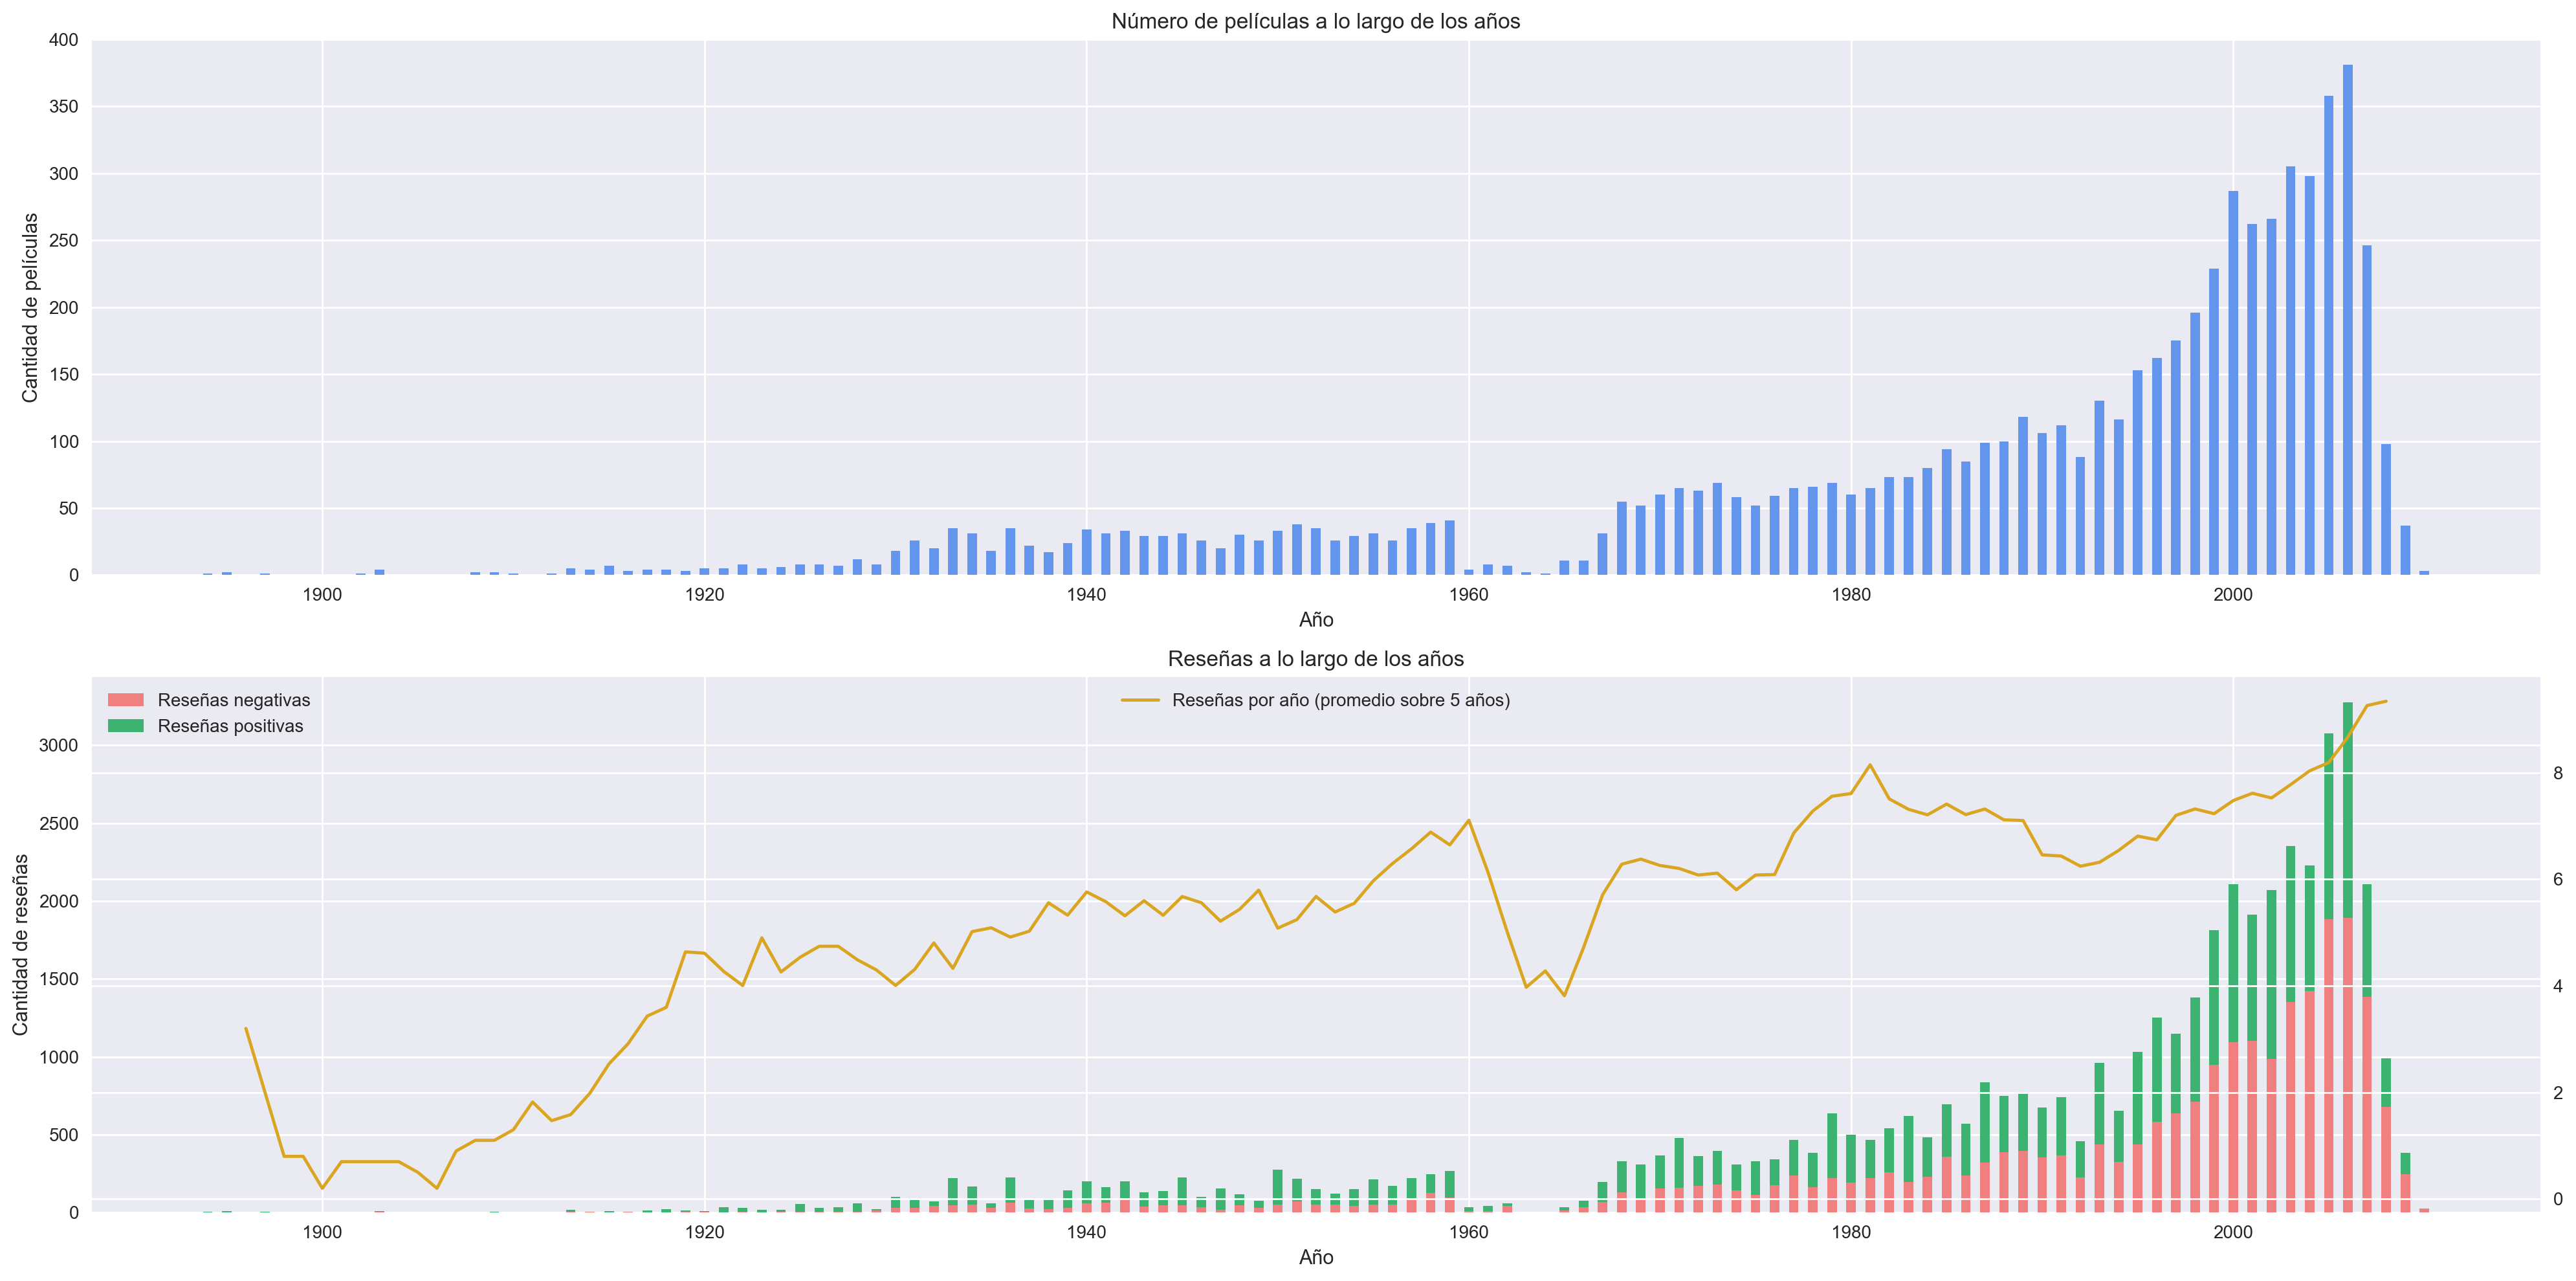

In [3]:
fig, axs = plt.subplots(2, 1, figsize=(20, 10))

# # Figura 1
ax = axs[0]

x = np.array(range(1894, 2011))
y_1 = data[['tconst', 'start_year']].drop_duplicates()['start_year'].value_counts().sort_index()
y_1 = y_1.reindex(index=np.arange(y_1.index.min(), max(y_1.index.max(), 2011))).fillna(0)
ax.bar(x, height=y_1, width=0.5, color="cornflowerblue")

ax.set_title("Número de películas a lo largo de los años")
ax.set_xlabel("Año")
ax.set_ylabel("Cantidad de películas")

# Figura 2
ax = axs[1]

x = np.array(range(1894, 2011))
y_2 = data.groupby(['start_year', 'pos'])['pos'].count().unstack()
y_2 = y_2.reindex(index=np.arange(y_2.index.min(), max(y_2.index.max(), 2011))).fillna(0)
ax.bar(x, height=y_2.iloc[:, 0], width=0.5, color="lightcoral", label="Reseñas negativas")
ax.bar(x, height=y_2.iloc[:, 1], bottom=y_2.iloc[:, 0], width=0.5, color="mediumseagreen", label="Reseñas positivas")
ax.legend()

# Ploteo extra en figura 2
axt = ax.twinx()

y_3 = data['start_year'].value_counts().sort_index()
y_3 = y_3.reindex(index=np.arange(y_3.index.min(), max(y_3.index.max(), 2011))).fillna(0)
y_3 = (y_3/y_1).fillna(0)
y_3 = y_3.reset_index(drop=True).rolling(5, center=True).mean()
axt.plot(x, y_3, color="goldenrod", label="Reseñas por año (promedio sobre 5 años)")
axt.legend(loc="upper center")

ax.set_title("Reseñas a lo largo de los años")
ax.set_xlabel("Año")
ax.set_ylabel("Cantidad de reseñas")

fig.tight_layout()

Podemos observar la cantidad de películas que se hicieron a lo largo de los años, procederé a explicar algunos puntos de interés.  
* El número de películas disminuye a partir del 2006 mientras que el número de reseñas continua en su tendencia positiva.
* En la década de los 60s no se tiene registro de películos, por ello es que la media de críticas también disminuye.
* Las reseñas positivas dominan en las decadas de los 20's hsata los 80's pero las críticas negativas comienzan a tomar fuerza de los 80's en adelante, una razón posible es la creación masiva de películas basura.

### Reseñas por pelúcula

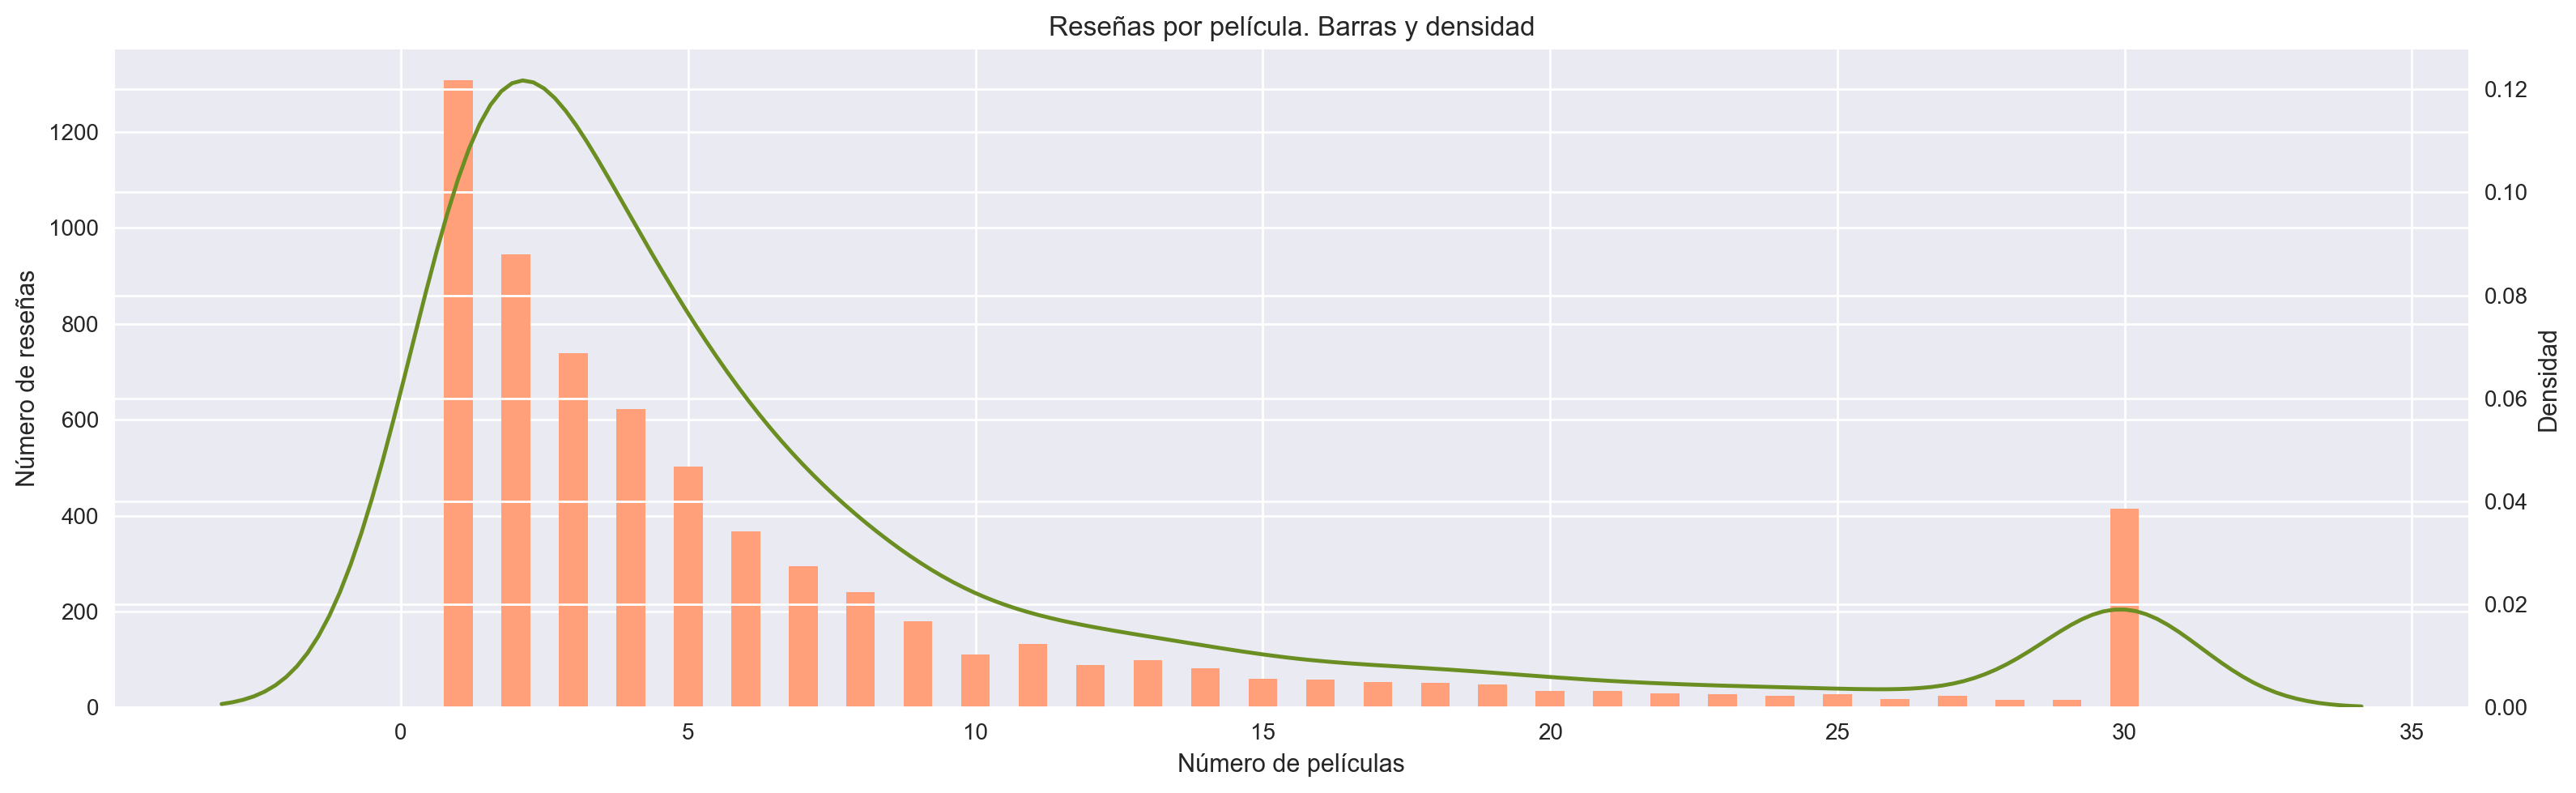

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(16, 5))

# Figura 1 
x = np.array(range(1,31))
y_1 = data.groupby('tconst')['review'].count().value_counts().sort_index()
ax.bar(x, y_1, width= 0.5, color="lightsalmon")

axt = ax.twinx()
y_2 = data.groupby('tconst')['review'].count()
sns.kdeplot(y_2, ax=axt, color="olivedrab")
axt.set_ylabel("Densidad")


ax.set_title('Reseñas por película. Barras y densidad')
ax.set_xlabel("Número de películas")
ax.set_ylabel("Número de reseñas")

fig.tight_layout()


En la gráfica podemos observar dos representaciones distintas para un mísmo fenómeno, el número de reseñas por película. Mientras que las bsarras nos pueden dar el número exacto de películas con N reseñas, la curva de densidad nos dice las probabilidades de dichos valores. El comportamiento tiene la siguiente explicación. Las películas tienen un comportamiento en el que tienen pocas reseñas (de 1 a 5) ya que pueden ser películas muy desconocidas. el pico que se ve en 30 reseñas es muy probablemente a películas "blockbuster" o películas tan malas que la gente hace reseñas solamente para burlarse de ellas.  

### Distribución despues de división entre entrenamiento y prueba.

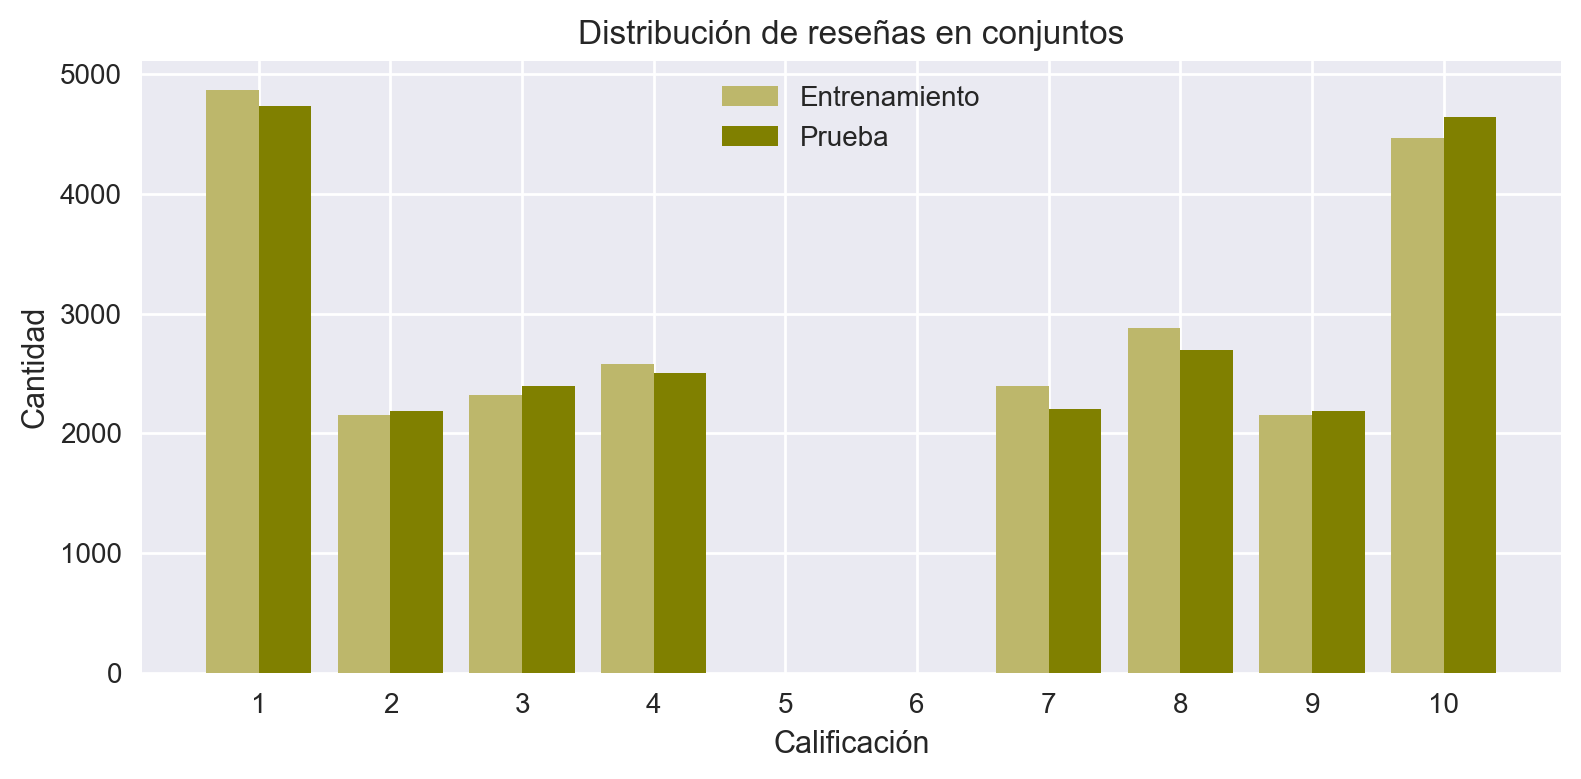

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
x = np.array(range(1,11))

y_1 = data.query('ds_part == "train"')['rating'].value_counts().sort_index()
y_1 = y_1.reindex(index=np.arange(min(y_1.index.min(), 1), max(y_1.index.max(), 11))).fillna(0)
ax.bar(x-0.2, y_1, width=0.4, color="darkkhaki", label="Entrenamiento")

y_2 = data.query('ds_part == "test"')['rating'].value_counts().sort_index()
y_2 = y_2.reindex(index=np.arange(min(y_2.index.min(), 1), max(y_2.index.max(), 11))).fillna(0)
ax.bar(x+0.2, y_2, width=0.4, color="olive", label="Prueba")

ax.set_title("Distribución de reseñas en conjuntos")
ax.legend(loc="upper center")
ax.set_xticks(range(1,11))
ax.set_xlabel("Calificación")
ax.set_ylabel("Cantidad")
fig.tight_layout()

Hacer una buena división en una base de datos entre entrenamiento y prueba es mantener la distribución de los valores, ésta gráfica demuestra como la distribución se mantiene despues de la división. Es interesante observar que no hay calificaciónes con 5 y 6 de calificación, ignoro la razón pero es muy interesante.  

### Distribuciones de reseñas en conjuntos de entrenamiento y prueba.

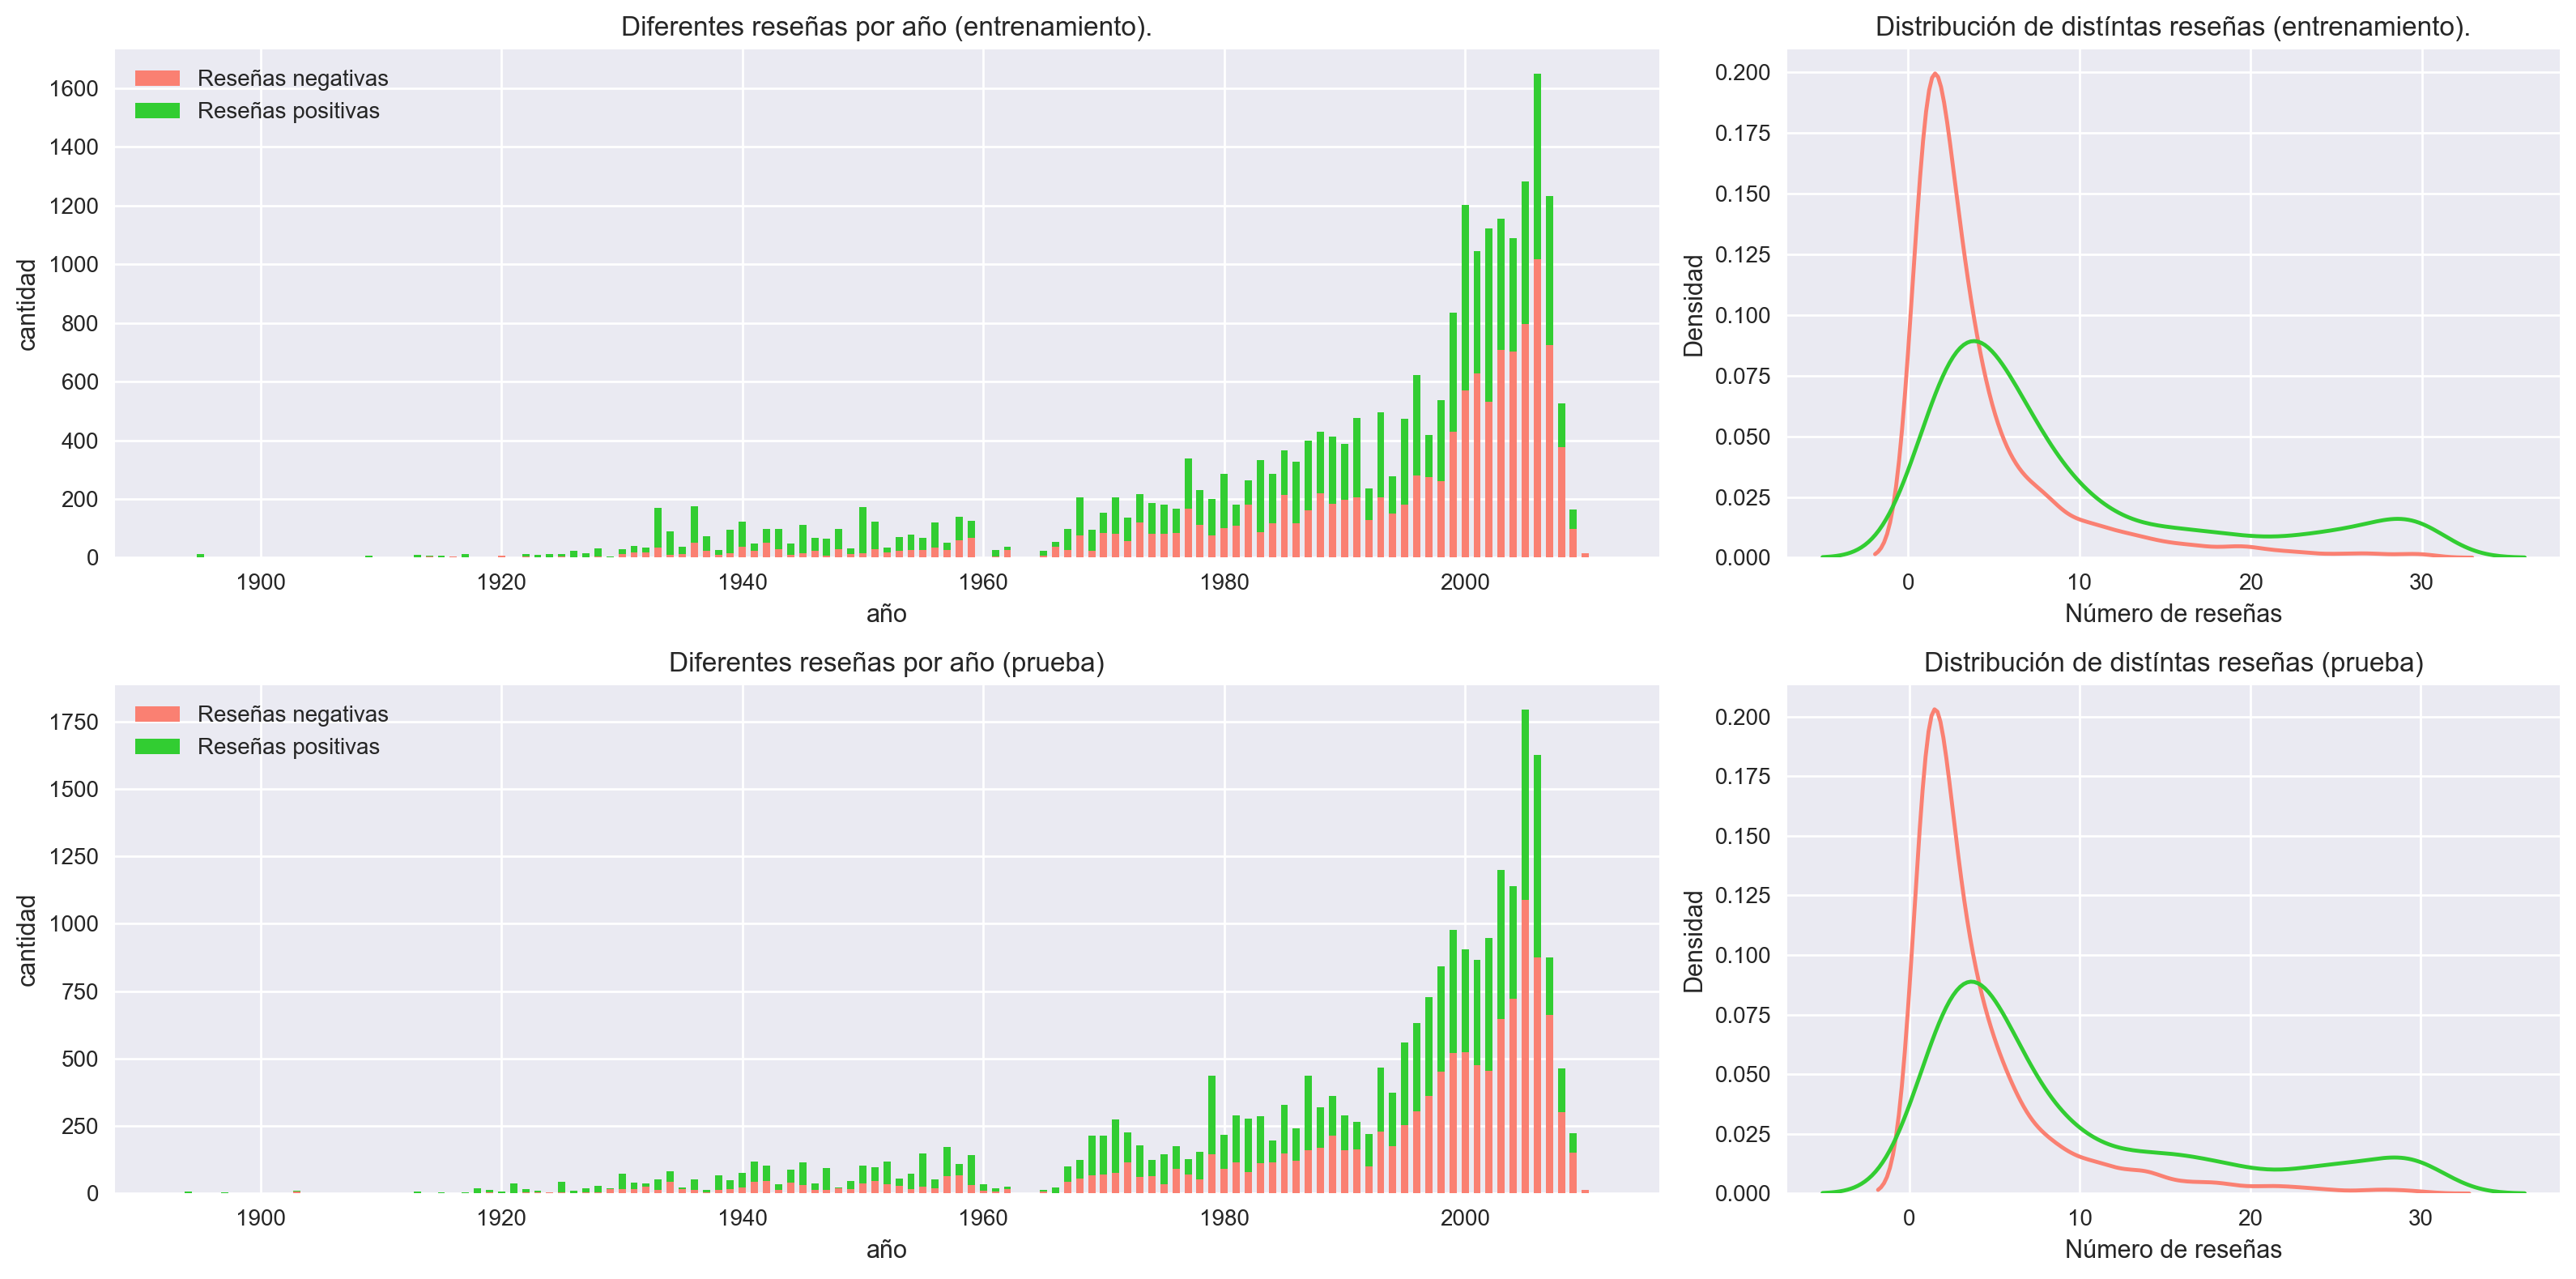

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))


ax = axs[0][0]
x = np.arange(data["start_year"].min(), data["start_year"].max()+1)

y_1 = data.query("(ds_part == 'train')").groupby(by=["start_year", "pos"])["pos"].count().unstack()
y_1 = y_1.reindex(index=x).fillna(0)
ax.bar(x, y_1[0], color="salmon", width=0.6, label="Reseñas negativas")
ax.bar(x, y_1[1], bottom=y_1[0], color="limegreen", width=0.6, label="Reseñas positivas")

ax.set_title("Diferentes reseñas por año (entrenamiento).")
ax.set_xlabel("año")
ax.set_ylabel("cantidad")
ax.legend()


ax = axs[0][1]

y_1 = data.query("ds_part == 'train'").groupby(by=['tconst', 'pos'])["pos"].count().unstack()
sns.kdeplot(y_1[0], color='salmon', label='negative', ax=ax)
sns.kdeplot(y_1[1], color='limegreen', label='positive', ax=ax)

ax.set_title("Distribución de distíntas reseñas (entrenamiento).")
ax.set_ylabel("Densidad")
ax.set_xlabel("Número de reseñas")


ax = axs[1][0]
x = np.arange(data["start_year"].min(), data["start_year"].max()+1)

y_1 = data.query("(ds_part == 'test')").groupby(by=["start_year", "pos"])["pos"].count().unstack()
y_1 = y_1.reindex(index=x).fillna(0)
ax.bar(x, y_1[0], color="salmon", width=0.6, label="Reseñas negativas")
ax.bar(x, y_1[1], bottom=y_1[0], color="limegreen", width=0.6, label="Reseñas positivas")

ax.set_title("Diferentes reseñas por año (prueba)")
ax.set_xlabel("año")
ax.set_ylabel("cantidad")
ax.legend()


ax = axs[1][1]

y_1 = data.query("ds_part == 'test'").groupby(by=['tconst', 'pos'])["pos"].count().unstack()
sns.kdeplot(y_1[0], color='salmon', label='negative', ax=ax)
sns.kdeplot(y_1[1], color='limegreen', label='positive', ax=ax)

ax.set_title("Distribución de distíntas reseñas (prueba)")
ax.set_ylabel("Densidad")
ax.set_xlabel("Número de reseñas")


fig.tight_layout()

En ésta gráfica tenemos la cantidad de críticas positivas y negarivas (Gráficas de la izuqierda) y las curvas de densidad (gráficas de la derecha). Las conclusiones con muy similares a la primera y la tercera gráfica. Y viendo curvas tan similares se demuestra que la división  de la base de datos ha sido efectiva.  

## Procesamiento para evaluación.

Se harán varios modelos, cada modelo se evaluará con una función la cual nos dará las gráficas ROC, área bajo la curva (AUC), F1 score, sensibilidad y reconocimiento. Los respultados se mostrarán la final de cada modelo.

### Función evaluadora y graficadora de modelos.

In [7]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

### Normalización.

Antes de entrenar a cualquier modelo devemos hacer nuestra normalización. La normalización es básicamente transformar las letras a minúsculas y retirar cualquer símbolo que no sea letra o comilla simple.

In [8]:
def text_normalization(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z']", " ", text)
    text = " ".join(text.split())
    return text

In [9]:
data['review_norm'] = data["review"].apply(text_normalization)

print(data["review"].iloc[3])
print(data["review_norm"].iloc[3])

Um .... a serious film about troubled teens in Singapore, a country I have not much knowledge on but have the previous wrong impression that all the kids there are highly disciplined and controlled by their family and government. Well, I guess I am wrong, just like other cities/ countries, they also have their troubled teens who also lead the not so surprising rebellious way of life of drugs, fights, bad language, and .... many other obvious signs of being a bad boy. The surprising part of this film isn't really about how these kids running around causing themselves and others trouble, but rather the subtle gayness hidden behind their so call loyalty between them. The bond between these "brothers" may very well originated from an unconscious gay tendency inside these boys. Though it isn't uncommon for str8 guys to have very close friendship with each other, but watch this film closely, it should be entering all sorts of gay film festivals and I would not be surprised that it may win it

## Creación y evaluación de modelos.

### Modelo 0 - Dummy (constante a 0). 
Este modelo dará como reseña negativa cualquier predicción que realice. es un modelo para evaluar casos obios y ver cómo las máquinas que realizaremos mejorarán los resultados.

In [224]:
data_train = data.query('ds_part == "train"').copy()
data_test = data.query('ds_part == "test"').copy()

X_train_0 = data_train["review_norm"]
y_train_0 = data_train["pos"]
X_test_0 = data_test["review_norm"]
y_test_0 = data_test["pos"]

model_0 = DummyClassifier(constant=0)
model_0.fit(X_train_0, y_train_0)

DummyClassifier(constant=0)

           train  test
Exactitud    NaN   NaN
F1           0.0   0.0
APS          0.5   0.5
ROC AUC      0.5   0.5


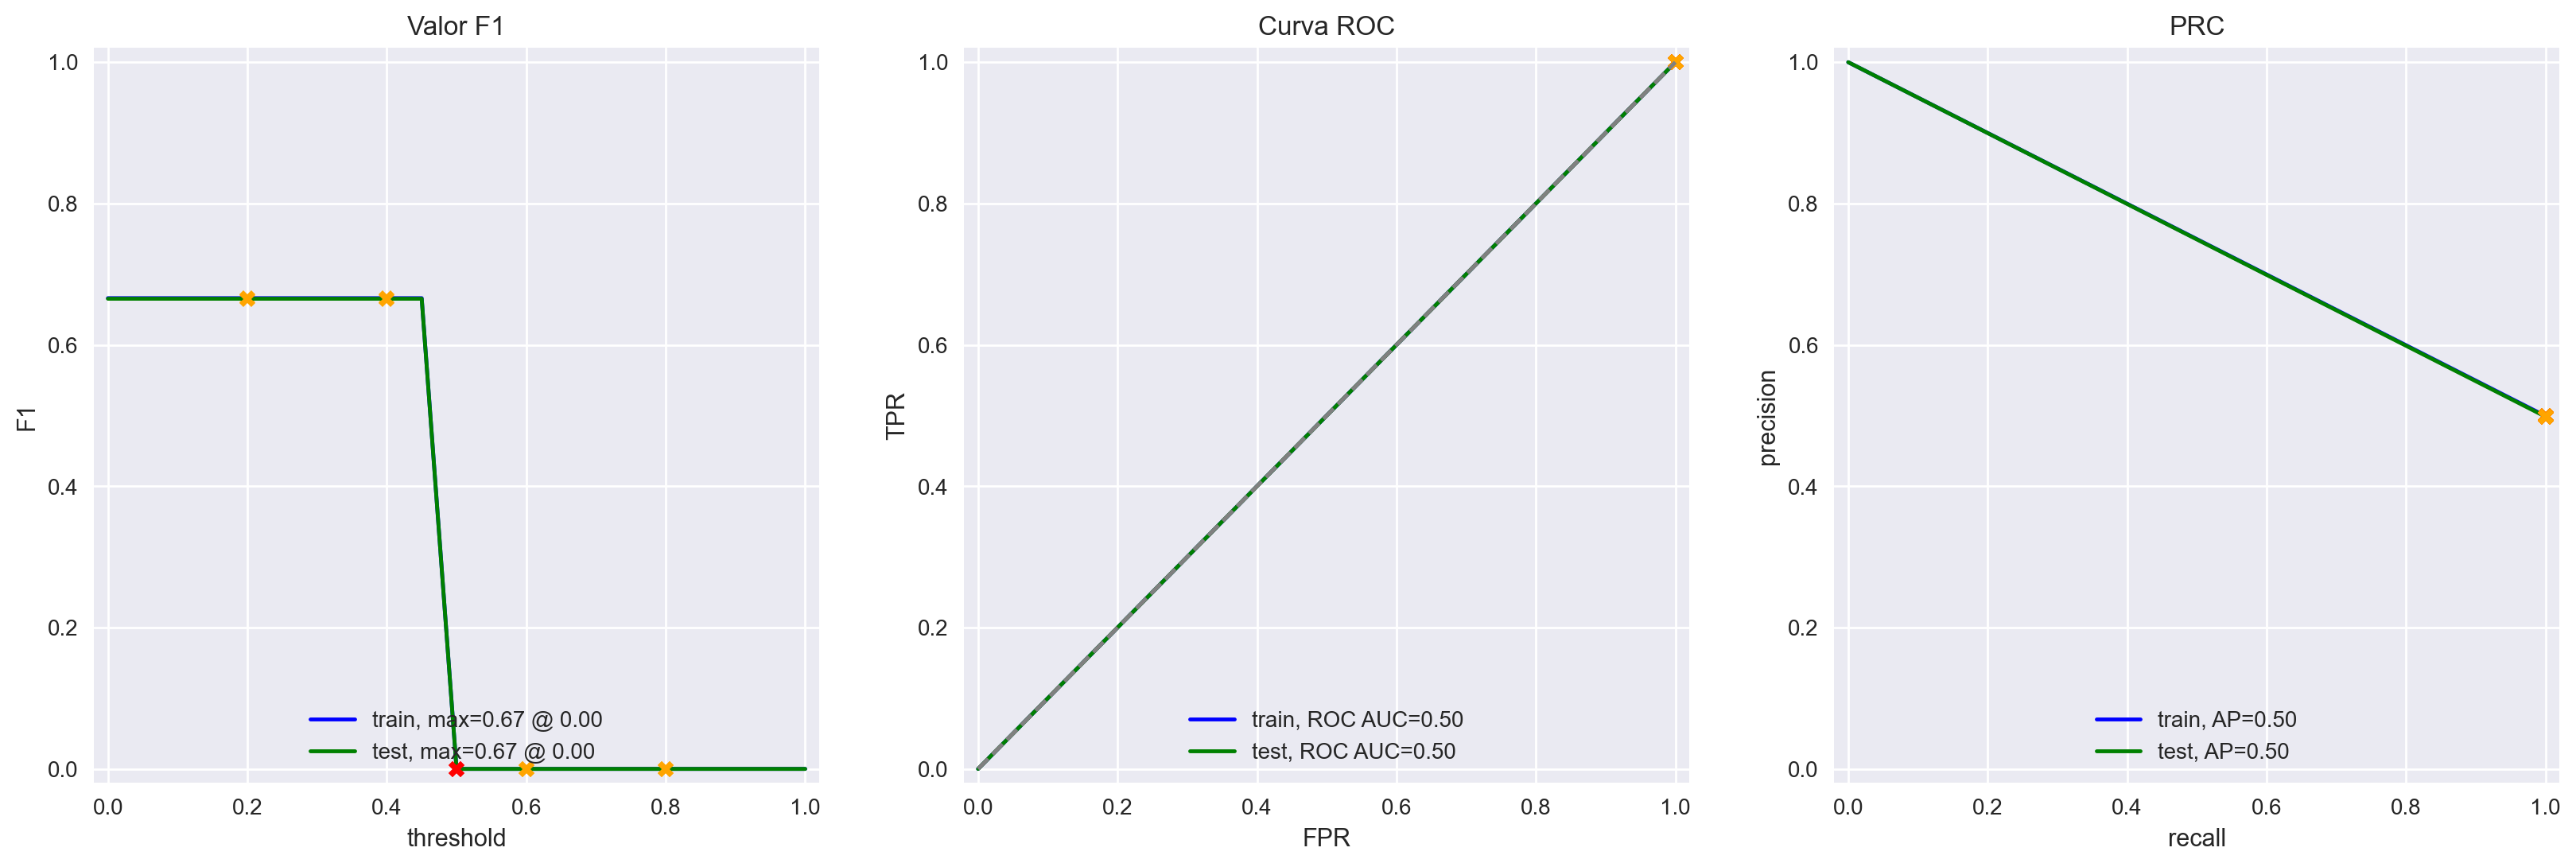

In [225]:
evaluate_model(model_0, X_train_0, y_train_0, X_test_0, y_test_0)

En la primera gráfica vemos el cambio del "F1 score" con respecto al cambio en el threshold. Vwemos como tanto en el entrenamiento como en la prueba tiene un rendimiento del 0.67 lo cual es muy bajo.    
En la curva ROC Vemos que es un fesempeño muy mediocre, el AUC es simplemente 0.5 lo cual es lo mas bajo que se puede tener.  
La curva PCR que es muy similar a la curva ROC nos dá también un áriea de 0.5, un desempeño malo.

### Modelo 1 - NLTK, TF-IDF, LR.

Este modelo se usará la biblioteca de python para procesamiento de lenguaje natural NLTK, y se le asignará un peso a cada palabra dependiendo de su importancia con la función TfidfVectorizer. Las características resultantes serán clasificadas con un clasificador de regresión logística.


In [256]:
data_train = data.query('ds_part == "train"').copy()
data_test = data.query('ds_part == "test"').copy()

stop_words = list(stopwords.words("english"))

corpus_train = data_train["review_norm"]
corpus_test = data_test["review_norm"]


count_tf_idf_1 = TfidfVectorizer(stop_words=stop_words)
features_train = count_tf_idf_1.fit_transform(corpus_train)
features_test = count_tf_idf_1.transform(corpus_test)

In [227]:
model_1 = LogisticRegression()
model_1.fit(features_train, data_train["pos"])

LogisticRegression()

           train  test
Exactitud    NaN   NaN
F1          0.94  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


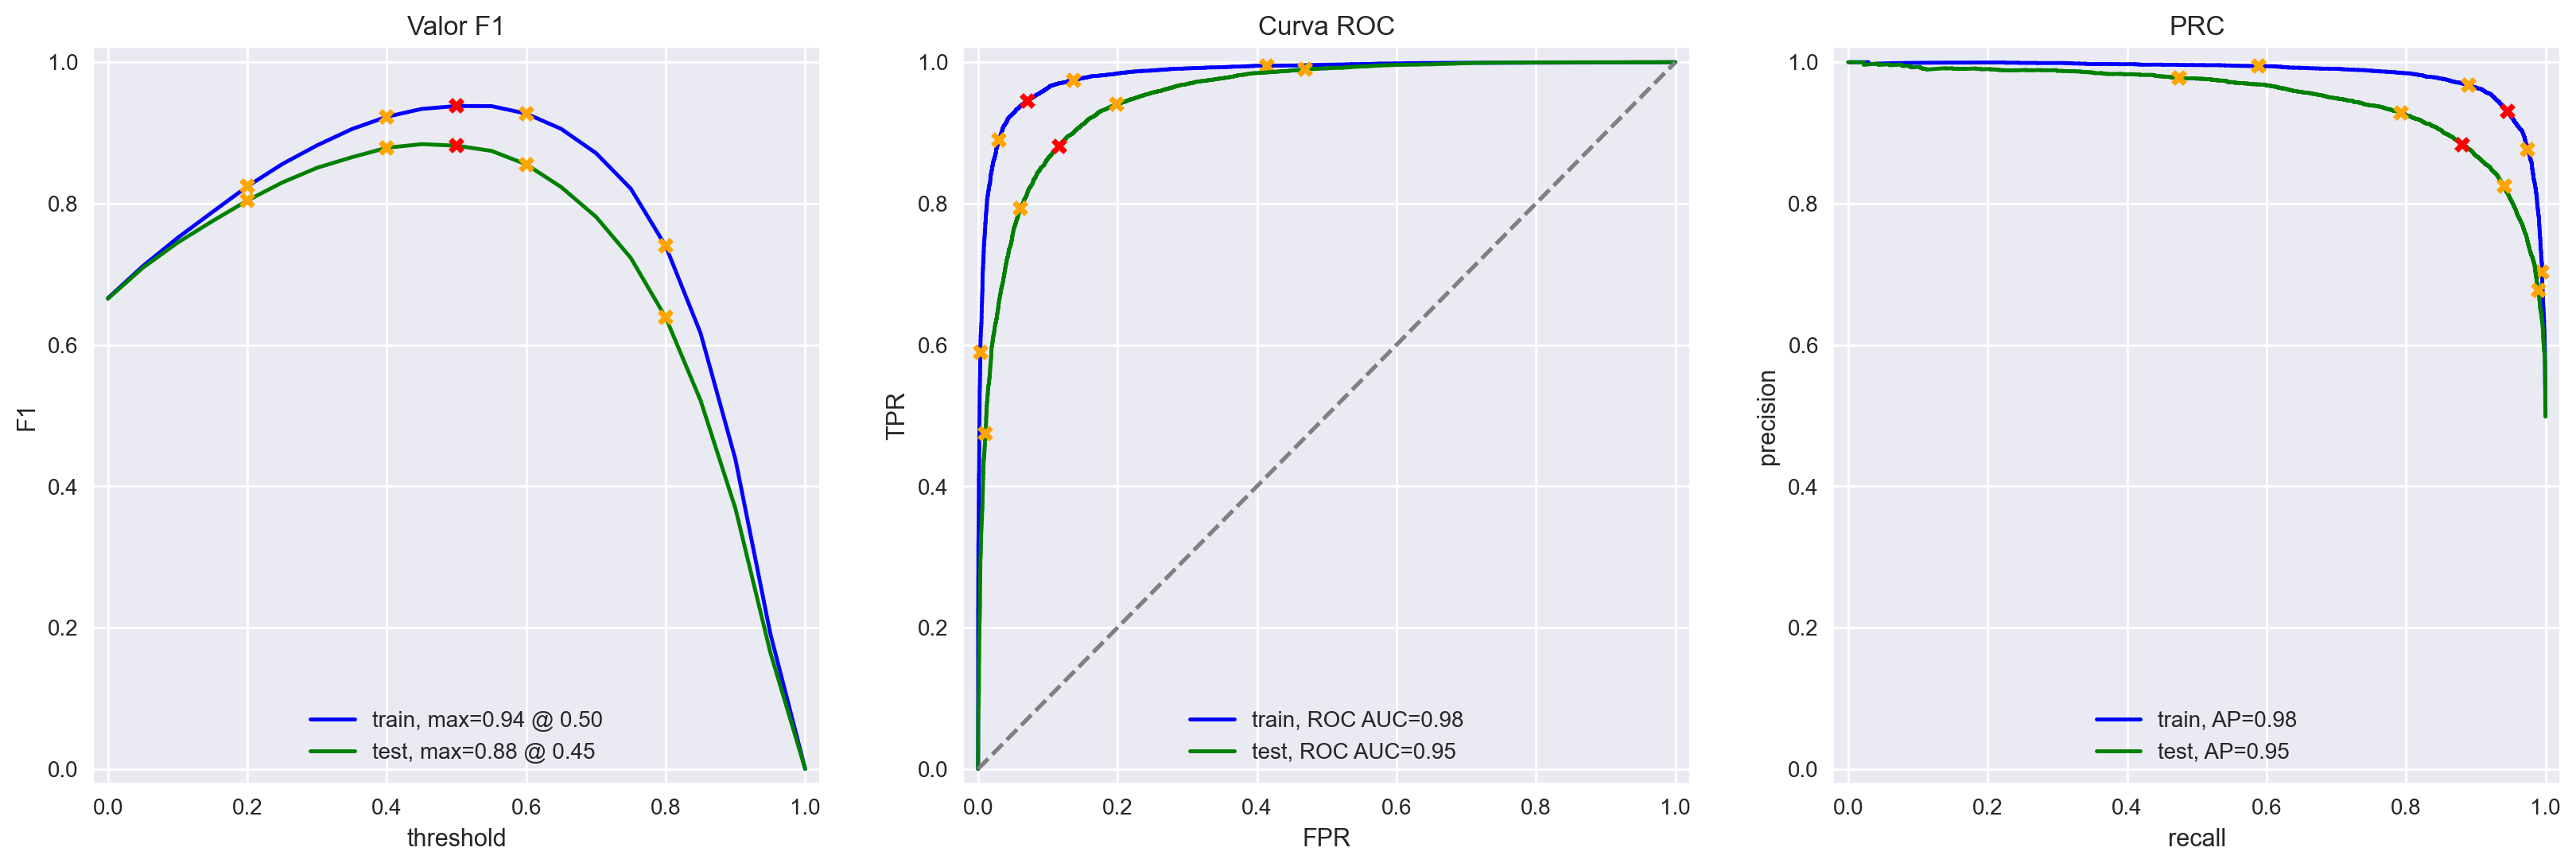

In [228]:
evaluate_model(model_1, features_train, data_train["pos"], features_test, data_test["pos"])

Ahora vemos un resultado mucho mas aceptable. En la curva de vlaores F1 vemos que con una sensibilidad cercana al 0.5 podemos tener el mejor desempeño 0.94.

Las curvas ROC y PR nos dicen algo muy similar, que tenemos un gran desempeño cambiando nuestros threshold. Los calres ROC-AUC y PR-AUC son del 0.98 y 0.95 para los conjuntos de entrenamiento y prueba.

### Modelo 2 - spaCy, TF-IDF y LR

Ahora probaaremos lematizando las palabras antes de introducirlas a nuestro valorador TF-IDF. La idea de esto es devolver todas las palabras a su "raíz" para que todas las palabras como gustó gusta gustaba gustará, se transformen en su "raíz" gustar y el contador TF-IDF sea mas efectivo.

In [229]:
def lemmatizer(text):
    lemmas = [token.lemma_ for token in nlp(text)]
    return ' '.join(lemmas)

In [230]:
data["review_lematized"] = data["review_norm"].apply(lemmatizer)

In [231]:
data_train = data.query('ds_part == "train"').copy()
data_test = data.query('ds_part == "test"').copy()

corpus_train = data_train["review_lematized"]
y_train = data_train["pos"]
corpus_test = data_test["review_lematized"]
y_test = data_test["pos"]

In [267]:
count_tf_idf_2 = TfidfVectorizer(stop_words=stop_words)
features_train = count_tf_idf_2.fit_transform(corpus_train)
features_test = count_tf_idf_2.transform(corpus_test)

           train  test
Exactitud    NaN   NaN
F1          0.93  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


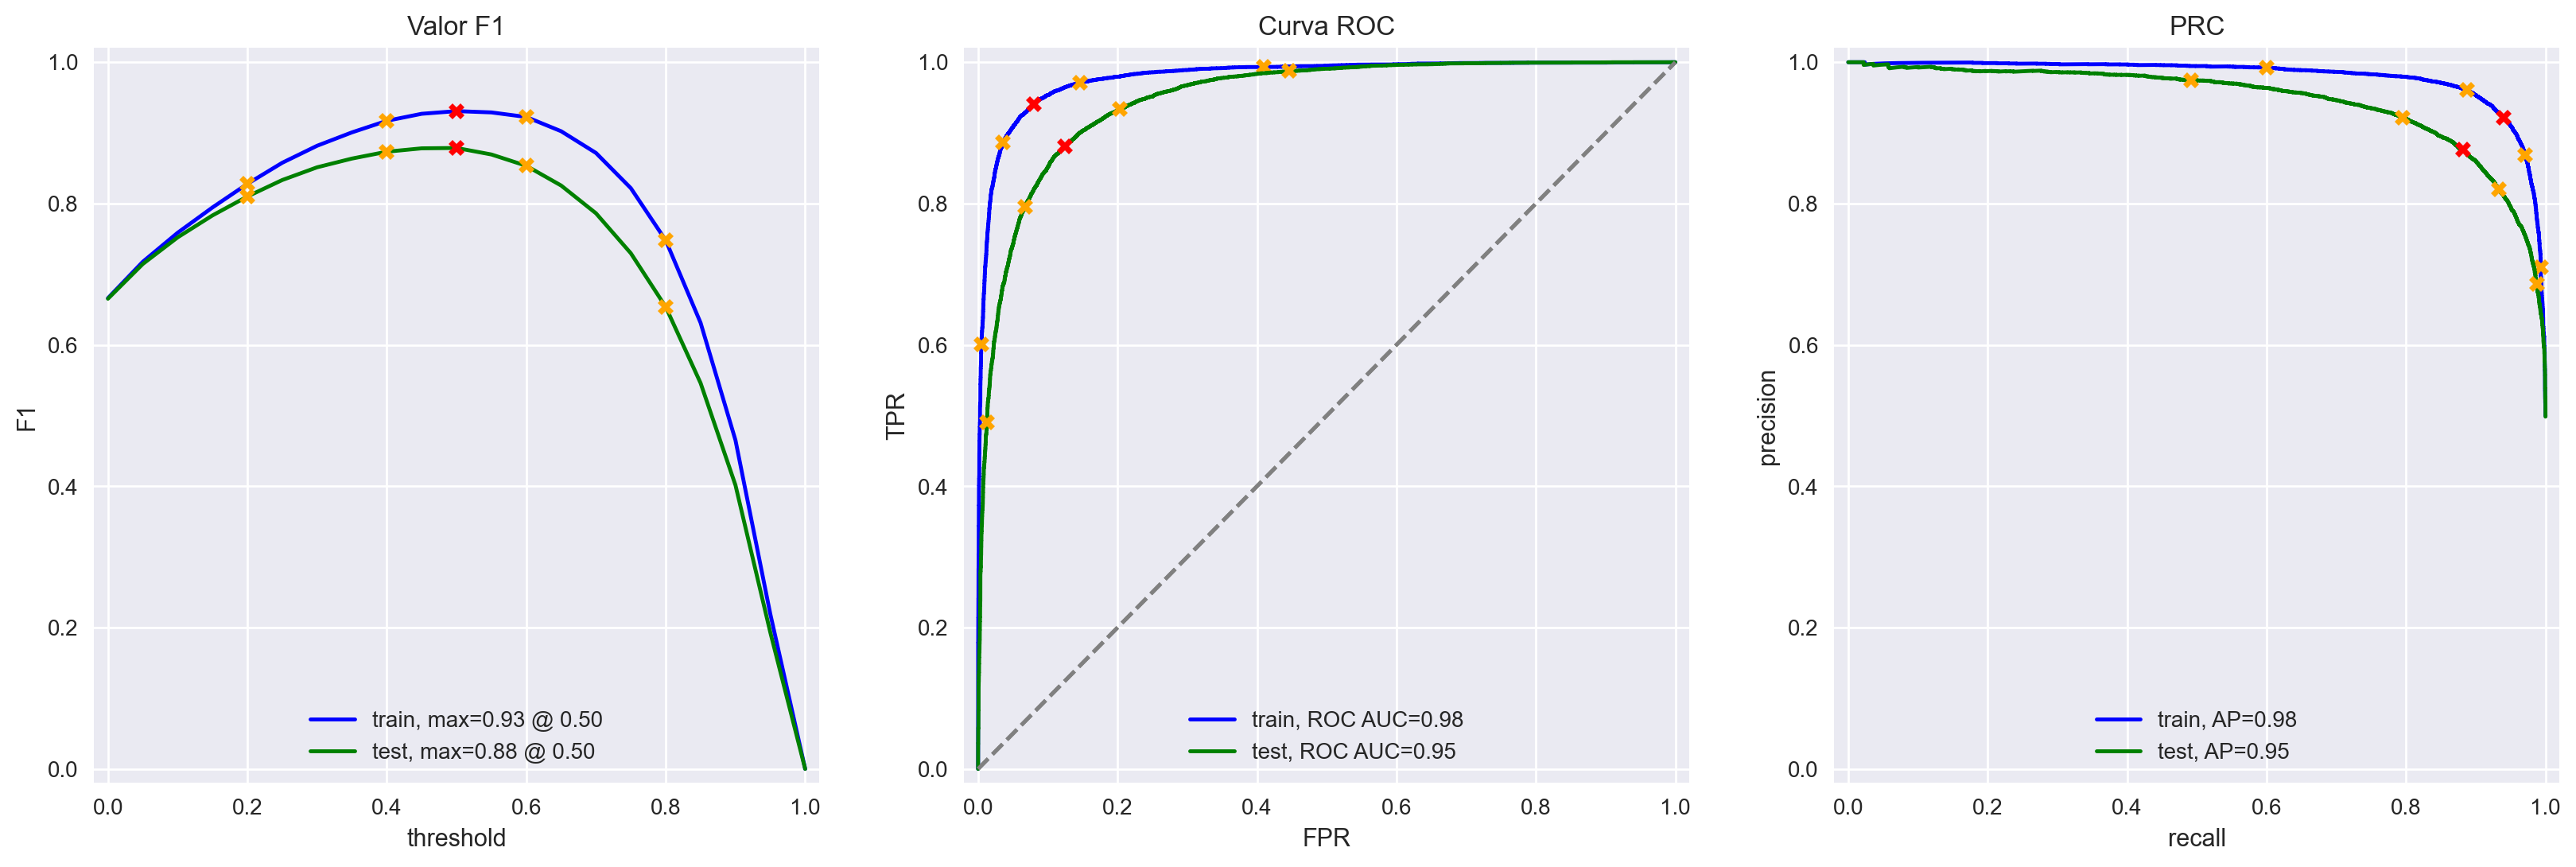

In [233]:
model_2 = LogisticRegression()
model_2.fit(features_train, data_train["pos"])
evaluate_model(model_2, features_train, y_train, features_test, y_test)

A pesar de tener una mejora teórica en el modelo el modelo da un resultado muy similar al anterior, el cual es MUY bueno.

### Modelo 3 - spaCy, TF-IDF y LGBMClassifier.

Ahora ahoremos una modificación en el clasificador, si un clasificador en regresión lineal funciona bien, suponemos que un arreglo de modelos conectados en serie podrá funcionar mejor.

In [258]:
data_train = data.query('ds_part == "train"').copy()
data_test = data.query('ds_part == "test"').copy()

corpus_train = data_train["review_lematized"]
y_train = data_train["pos"]
corpus_test = data_test["review_lematized"]
y_test = data_test["pos"]

count_tf_idf_3 = TfidfVectorizer(stop_words=stop_words)
features_train = count_tf_idf_3.fit_transform(corpus_train)
features_test = count_tf_idf_3.transform(corpus_test)

In [235]:
ne_cases = np.array(range(10,11))*100
lr_cases = 1 / (10**np.array(range(5)))

learning_rate = []
estimators = []
metric_r2 = []
iter = 0

for r in lr_cases:
    for n in ne_cases:
        iter += 1
        model_3 = LGBMClassifier(n_estimators = n, learning_rate = r, random_state=seed, verbose = -1)
        model_3.fit(features_train, y_train)
        y_pred_model_3 = model_3.predict(features_test)
        r2 = metrics.r2_score(y_test, y_pred_model_3)

        learning_rate.append(r)
        estimators.append(n)
        metric_r2.append(r2)

        print(f'Iteración {iter} --> LR: {r:.5f}, Est: {n}, R2: {r2:.4f}')

c:\Users\cesar_bclt08y\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Iteración 1 --> LR: 1.00000, Est: 1000, R2: 0.4463


c:\Users\cesar_bclt08y\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Iteración 2 --> LR: 0.10000, Est: 1000, R2: 0.4869


c:\Users\cesar_bclt08y\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Iteración 3 --> LR: 0.01000, Est: 1000, R2: 0.4305


c:\Users\cesar_bclt08y\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Iteración 4 --> LR: 0.00100, Est: 1000, R2: 0.1106


c:\Users\cesar_bclt08y\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Iteración 5 --> LR: 0.00010, Est: 1000, R2: 0.0367


In [236]:
lgbm_data = pd.DataFrame(dict(
    learing_rate = learning_rate,
    estimators = estimators,
    r2 = metric_r2
))
lgbm_data = lgbm_data.sort_values(by="r2", ascending=False).reset_index(drop=True)

In [237]:
model_3 = LGBMClassifier(n_estimators=lgbm_data.iloc[0,1], learning_rate=lgbm_data.iloc[0,0])
model_3.fit(features_train, y_train)

LGBMClassifier(learning_rate=np.float64(0.1), n_estimators=np.int64(1000))

c:\Users\cesar_bclt08y\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\cesar_bclt08y\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\cesar_bclt08y\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\cesar_bclt08y\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


           train  test
Exactitud    NaN   NaN
F1           1.0  0.87
APS          1.0  0.94
ROC AUC      1.0  0.95


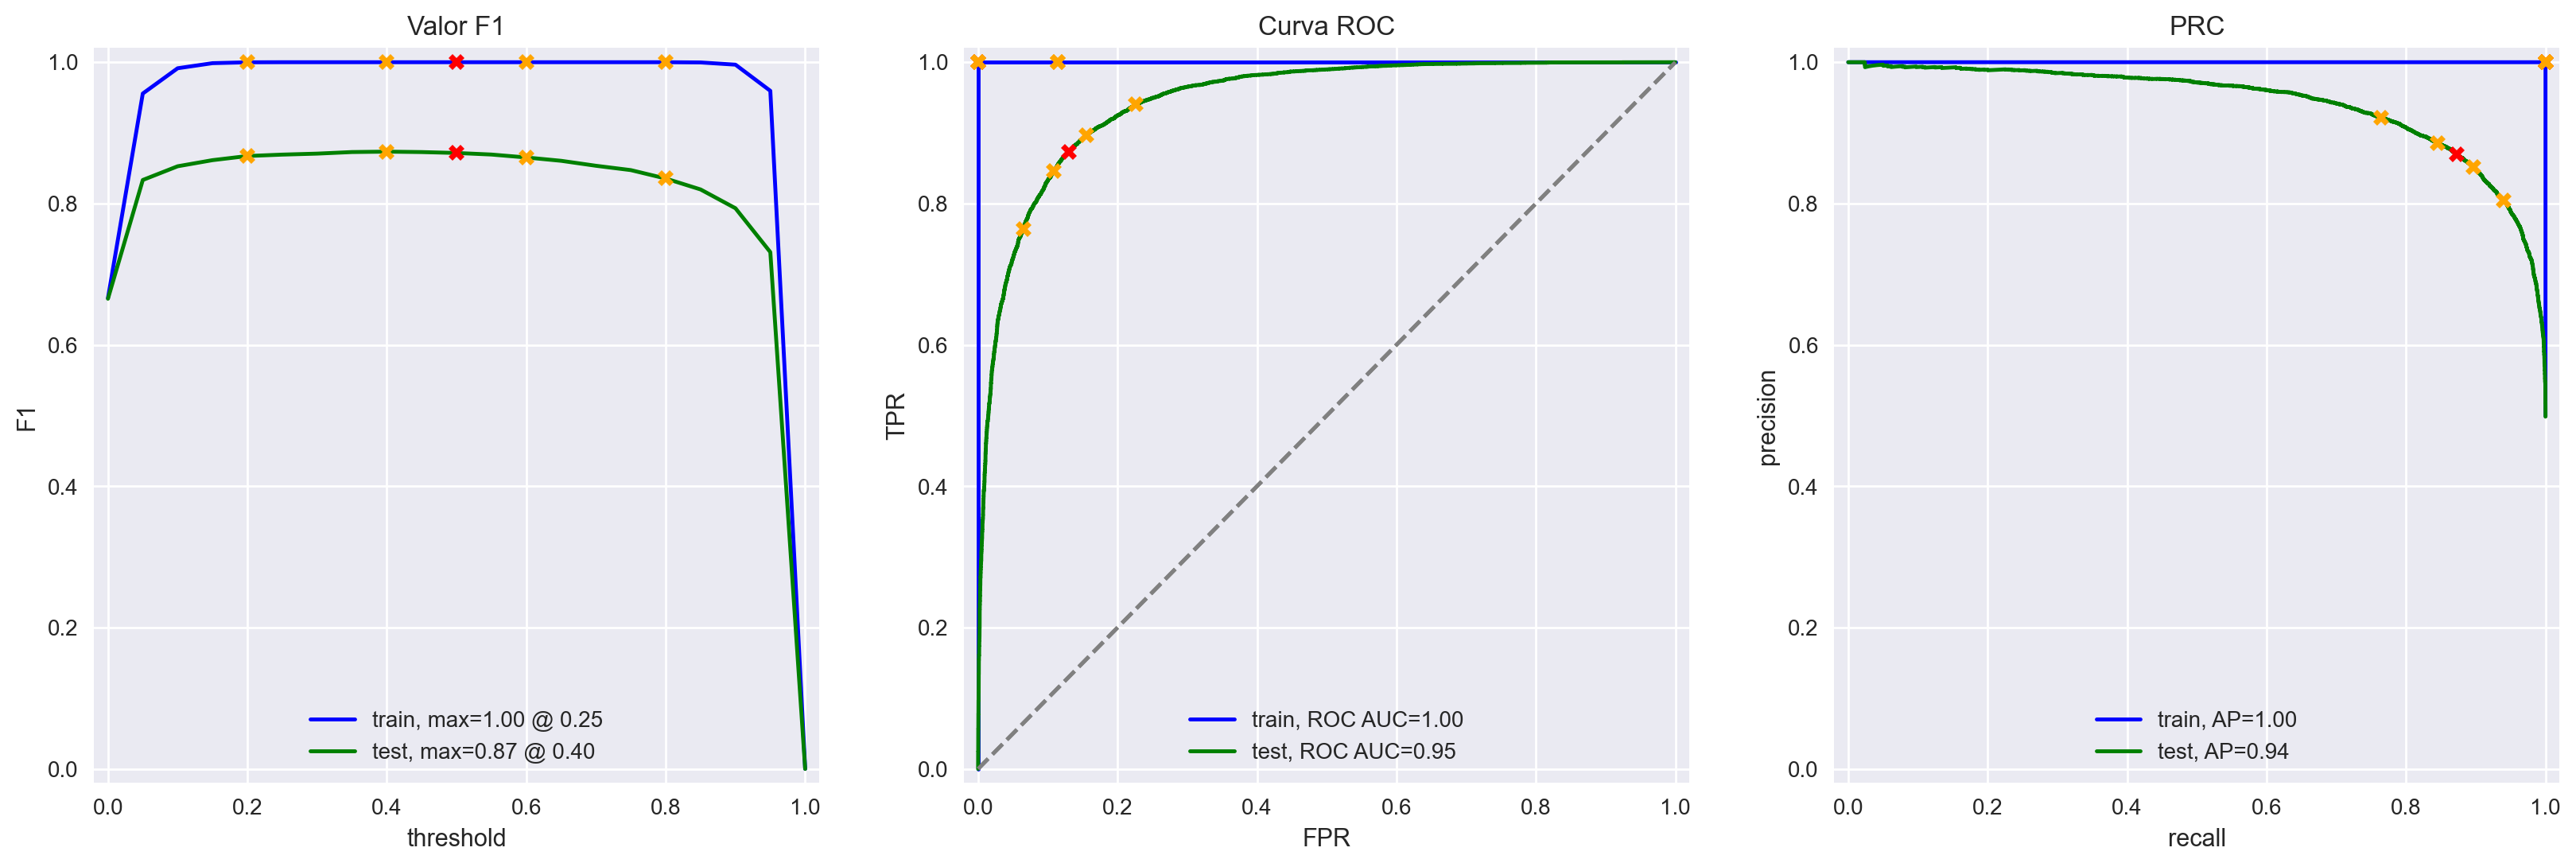

In [238]:
evaluate_model(model_3,features_train, y_train, features_test, y_test)

Podemos ver que en el entrenamiento logró resolver toda muestras en entrenamiento, pero podemos ver que sobreajustó su aprendizaje pues en el conjunto de prueba los resultados son ligeramente peores que en el modelo que usó solo regresión logística.

###  Modelo 4 - BERT
Ahora haremos el modelo BERT, este modelo transforma los textos en tokens-lemmas-insertados antes de clasificar. los insertados son vectores para cada palabra que contienen la idea de la palabra junto a su contexto, es una de las herramientas más útiles y actuales en la comprensión de textos.

In [10]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [11]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):

    ids_list = []
    attention_mask_list = []

    # texto al id de relleno de tokens junto con sus máscaras de atención 
       
    # <escribe tu código aquí para crear ids_list y attention_mask_list>
    for input_text in texts:
        ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)

    ids_np = np.array(ids_list)
    attention_mask_np = np.array(attention_mask_list)
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Uso del dispositivo {device}.')
    
    # obtener insertados en lotes
    
    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_np)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_np[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_np[batch_size*i:batch_size*(i+1)]).to(device)
        
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [214]:
data_train = data.query('ds_part == "train"').copy()
data_test = data.query('ds_part == "test"').copy()

corpus_train = data_train["review_norm"]
y_train = data_train["pos"]
corpus_test = data_test["review_norm"]
y_test = data_test["pos"]

In [216]:
# Dividí la transformación en pedazos porque la ram no me daba para llamar la función para todo el conjunto a la vez.

# Hago un primer entrenamiento con 3 valores, esto tiene dos objetivos.
#   * Crear y guardar la variable "train_features.npy"
#   * Quitar algunas muestras para que las restantes tengan un divisor con el que pueda trabajar. en este caso 1133.
pointer = 0
features_train_aux = BERT_text_to_embeddings(corpus_train[pointer:pointer+3], force_device="cpu")
pointer += 3
np.save("train_features.npy", features_train_aux)

# Hago el bucle que carga la variable guardada, genera los embeddings y se los acopla al final.
step = 1133
for i in np.arange(3,corpus_train.shape[0],step):
    features_train = np.load("train_features.npy")
    features_train_aux = BERT_text_to_embeddings(corpus_train[i:i+step], force_device="cpu")    
    features_train = np.vstack((features_train, features_train_aux))
    np.save("train_features.npy", features_train)

Uso del dispositivo cpu.


100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Uso del dispositivo cpu.


100%|██████████| 12/12 [12:56<00:00, 64.72s/it]


Uso del dispositivo cpu.


100%|██████████| 12/12 [09:51<00:00, 49.29s/it]


Uso del dispositivo cpu.


100%|██████████| 12/12 [09:33<00:00, 47.80s/it]


Uso del dispositivo cpu.


100%|██████████| 12/12 [09:28<00:00, 47.37s/it]


Uso del dispositivo cpu.


100%|██████████| 12/12 [09:24<00:00, 47.02s/it]


Uso del dispositivo cpu.


100%|██████████| 12/12 [09:24<00:00, 47.03s/it]


Uso del dispositivo cpu.


100%|██████████| 12/12 [09:34<00:00, 47.87s/it]


Uso del dispositivo cpu.


100%|██████████| 12/12 [09:25<00:00, 47.15s/it]


Uso del dispositivo cpu.


100%|██████████| 12/12 [09:26<00:00, 47.19s/it]


Uso del dispositivo cpu.


100%|██████████| 12/12 [09:24<00:00, 47.07s/it]


Uso del dispositivo cpu.


100%|██████████| 12/12 [09:29<00:00, 47.42s/it]


Uso del dispositivo cpu.


100%|██████████| 12/12 [09:25<00:00, 47.11s/it]


Uso del dispositivo cpu.


100%|██████████| 12/12 [09:25<00:00, 47.11s/it]


Uso del dispositivo cpu.


100%|██████████| 12/12 [09:24<00:00, 47.01s/it]


Uso del dispositivo cpu.


100%|██████████| 12/12 [09:26<00:00, 47.19s/it]


Uso del dispositivo cpu.


100%|██████████| 12/12 [09:26<00:00, 47.23s/it]


Uso del dispositivo cpu.


100%|██████████| 12/12 [09:32<00:00, 47.73s/it]


Uso del dispositivo cpu.


100%|██████████| 12/12 [09:27<00:00, 47.28s/it]


Uso del dispositivo cpu.


100%|██████████| 12/12 [09:27<00:00, 47.26s/it]


Uso del dispositivo cpu.


100%|██████████| 12/12 [09:25<00:00, 47.16s/it]


Uso del dispositivo cpu.


100%|██████████| 12/12 [09:28<00:00, 47.41s/it]


In [221]:
pointer = 0
first_samples = 5
features_test_aux = BERT_text_to_embeddings(corpus_test[pointer:pointer+first_samples], force_device="cpu")
pointer += first_samples
np.save("test_features.npy", features_test_aux)

# Hago el bucle que carga la variable guardada, genera los embeddings y se los acopla al final.
step = 905
for i in np.arange(pointer,corpus_test.shape[0],step):
    features_test = np.load("test_features.npy")
    features_test_aux = BERT_text_to_embeddings(corpus_test[i:i+step], force_device="cpu")    
    features_test = np.vstack((features_test, features_test_aux))
    np.save("test_features.npy", features_test)

Uso del dispositivo cpu.


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


Uso del dispositivo cpu.


100%|██████████| 10/10 [12:02<00:00, 72.21s/it]


Uso del dispositivo cpu.


100%|██████████| 10/10 [11:55<00:00, 71.59s/it]


Uso del dispositivo cpu.


100%|██████████| 10/10 [13:28<00:00, 80.86s/it]


Uso del dispositivo cpu.


100%|██████████| 10/10 [12:26<00:00, 74.60s/it]


Uso del dispositivo cpu.


100%|██████████| 10/10 [13:54<00:00, 83.50s/it]


Uso del dispositivo cpu.


100%|██████████| 10/10 [16:36<00:00, 99.69s/it]


Uso del dispositivo cpu.


100%|██████████| 10/10 [16:27<00:00, 98.79s/it]


Uso del dispositivo cpu.


100%|██████████| 10/10 [15:24<00:00, 92.41s/it]


Uso del dispositivo cpu.


100%|██████████| 10/10 [09:03<00:00, 54.31s/it]


Uso del dispositivo cpu.


100%|██████████| 10/10 [07:40<00:00, 46.01s/it]


Uso del dispositivo cpu.


100%|██████████| 10/10 [07:33<00:00, 45.38s/it]


Uso del dispositivo cpu.


100%|██████████| 10/10 [07:36<00:00, 45.63s/it]


Uso del dispositivo cpu.


100%|██████████| 10/10 [07:33<00:00, 45.34s/it]


Uso del dispositivo cpu.


100%|██████████| 10/10 [07:36<00:00, 45.68s/it]


Uso del dispositivo cpu.


100%|██████████| 10/10 [10:31<00:00, 63.13s/it]


Uso del dispositivo cpu.


100%|██████████| 10/10 [08:07<00:00, 48.73s/it]


Uso del dispositivo cpu.


100%|██████████| 10/10 [07:28<00:00, 44.90s/it]


Uso del dispositivo cpu.


100%|██████████| 10/10 [07:28<00:00, 44.82s/it]


Uso del dispositivo cpu.


100%|██████████| 10/10 [07:27<00:00, 44.77s/it]


Uso del dispositivo cpu.


100%|██████████| 10/10 [07:27<00:00, 44.77s/it]


Uso del dispositivo cpu.


100%|██████████| 10/10 [07:29<00:00, 44.97s/it]


Uso del dispositivo cpu.


100%|██████████| 10/10 [07:27<00:00, 44.80s/it]


Uso del dispositivo cpu.


100%|██████████| 10/10 [07:27<00:00, 44.73s/it]


Uso del dispositivo cpu.


100%|██████████| 10/10 [07:27<00:00, 44.75s/it]


Uso del dispositivo cpu.


100%|██████████| 10/10 [07:29<00:00, 44.92s/it]


Uso del dispositivo cpu.


100%|██████████| 10/10 [07:29<00:00, 44.91s/it]


In [239]:
# este codigo carga los insertados para entrenar un modelo de clasificación.

features_train = np.load("train_features.npy")
features_test = np.load("test_features.npy")

In [247]:
model_4 = LogisticRegression()
model_4.fit(features_train, y_train)


c:\Users\cesar_bclt08y\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

           train  test
Exactitud    NaN   NaN
F1          0.87  0.86
APS         0.94  0.94
ROC AUC     0.94  0.94


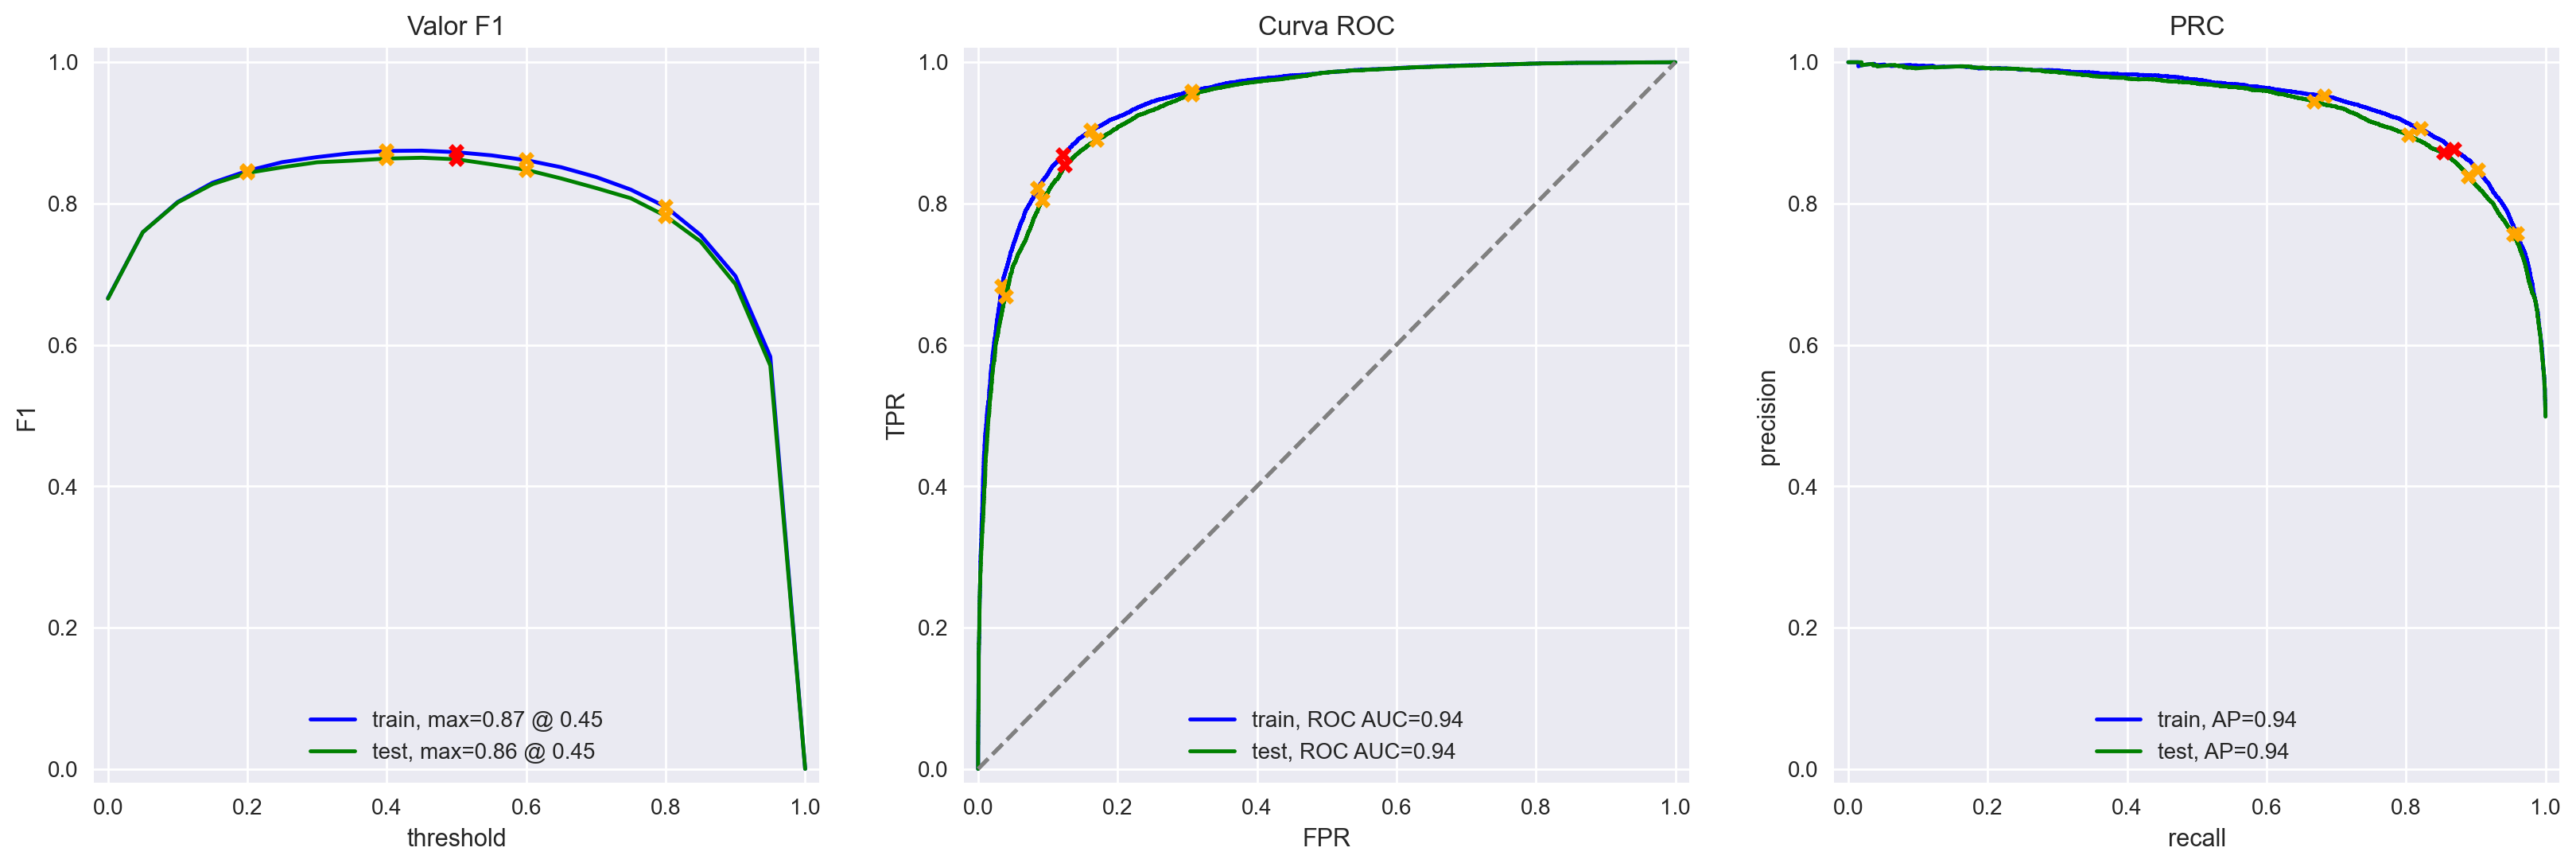

In [248]:
evaluate_model(model_4, features_train, y_train, features_test, y_test)

Podemos ver un desempeño menora alas anteriores en cuanto a F1 score, las vurvas roc y PR se miran bien, lo que hay que destacar es que se ve muy poco sobreajuste lo que habla de modelos muy bien entrenados.

## Evaluaciones finales.

Generaremos nuestras reseñas para evaluar todos los modelos anteriores.

In [255]:
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews["review_norm"] = my_reviews["review"].apply(text_normalization)
my_reviews["review_lematized"] = my_reviews["review_norm"].apply(lemmatizer)

### Modelo 1

In [265]:
corpus = my_reviews['review_norm']

features = count_tf_idf_1.transform(corpus)

my_reviews_pred_prob = model_1.predict_proba(features)[:, 1]

for i, review in enumerate(corpus.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.14:  i did not simply like it not my kind of movie
0.15:  well i was bored and felt asleep in the middle of the movie
0.53:  i was really fascinated with the movie
0.11:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.30:  i didn't expect the reboot to be so good writers really cared about the source material
0.47:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.82:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Modelo 2

In [269]:
corpus = my_reviews['review_lematized']

features = count_tf_idf_2.transform(corpus)

my_reviews_pred_prob = model_2.predict_proba(features)[:, 1]

for i, review in enumerate(corpus.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.20:  I do not simply like it not my kind of movie
0.14:  well I be bored and feel asleep in the middle of the movie
0.59:  I be really fascinate with the movie
0.13:  even the actor look really old and disinterested and they get pay to be in the movie what a soulless
0.27:  I do not expect the reboot to be so good writer really care about the source material
0.50:  the movie have its upside and downside but I feel like overall it be a decent flick I could see myse
0.03:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wil
0.92:  launch on netflix be a brave move I really appreciate be able to binge on episode after episode of t


### Modelo 3

In [270]:
corpus = my_reviews['review_lematized']

features = count_tf_idf_3.transform(corpus)

my_reviews_pred_prob = model_3.predict_proba(features)[:, 1]

for i, review in enumerate(corpus.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.54:  I do not simply like it not my kind of movie
0.31:  well I be bored and feel asleep in the middle of the movie
0.60:  I be really fascinate with the movie
0.12:  even the actor look really old and disinterested and they get pay to be in the movie what a soulless
0.15:  I do not expect the reboot to be so good writer really care about the source material
0.95:  the movie have its upside and downside but I feel like overall it be a decent flick I could see myse
0.06:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wil
0.98:  launch on netflix be a brave move I really appreciate be able to binge on episode after episode of t


c:\Users\cesar_bclt08y\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


### Modelo 4

In [271]:
corpus = my_reviews['review_lematized']

features = BERT_text_to_embeddings(corpus)

my_reviews_pred_prob = model_4.predict_proba(features)[:, 1]

for i, review in enumerate(corpus.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

Uso del dispositivo cpu.


100%|██████████| 1/1 [00:04<00:00,  4.64s/it]

0.37:  I do not simply like it not my kind of movie
0.01:  well I be bored and feel asleep in the middle of the movie
0.32:  I be really fascinate with the movie
0.01:  even the actor look really old and disinterested and they get pay to be in the movie what a soulless
0.17:  I do not expect the reboot to be so good writer really care about the source material
0.92:  the movie have its upside and downside but I feel like overall it be a decent flick I could see myse
0.04:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wil
0.96:  launch on netflix be a brave move I really appreciate be able to binge on episode after episode of t


## Conclusiones.

En este proyecto se llevaron a cabo pruebas para el procesamiento de textos y clasificación utilzando distintos tipos de modelos. el proyecto se dividió en varios bloques.

* **Carga de datos y análisis.** Para cada análisis se recomiendoa ir a la sección indicada para leerlo.
    * Se cargaron los datos y no se encontraron fallas en su recolección.
    * Se hizo un análisis sobre el número de películas para cada año. Se da un posible explicación al comportamiento.
    * Se realizó un análisis a las reseñas positivas y negativas dentro del conjunto de datos.
    * Se realizó un análisis en las distribuciones de los conjuntos de entrenamiento y prueba.
    * Se realizó un último análisis a la distribución de reseñas para cada película.  

* **Procesamiento para la generación de modelos.** El procesamiento fue poco pero se describe a continuación.
    * Se generó una función que ayuda a evaluar todos los modelos, la función utiliza predict_proba, por lo que modelos como SVM quedan fuera de esta función. La función toma los resultados para F1, ROC y PR con respecto al cambio en el threshold de desición.
    * Se normalizaron los textos para quitar simbolos extraños y poner todas las letras en minúsculas.  

* **Cración y evaluación de modelos.** Se crearon distintos modelos para probar distintos aproximaciones que se tienen al momento de procesar textos. 
    * **Modelo 0 (modelo dummy).** Un modelo de cordura para comparar con todos los siguientes modelos, su desempeño fue bajo como se esperaba. F1=0.62 en entrenamiento y F1=0.62 en prueba.
    * **Modleo 1 (NLKT, TF-IDF, LR).**, Un modelo que tokeniza las palabras y despues toma un peso de importancia dependiendo de las apareiciones en el texto, finaliza con una clasificación hecha con regresión logística. F1=0.94 en entrenamiento y F1=0.88 en prueba.
    * **Modelo 2 (spaCy, TF-IDF, LR).** Se generó un modelo que despues de tokenizar lemantiza las palabras (las expresa en su forma raíz) pra que puedan ser identificadas mejor con el vectorizador TF-IDF. Al final clasificacióms con un clasificador de regresión logística. F1=0.93 en entrenamiento y F1=0.88 en prueba.
    * **Modelo 3(spaCy, TF-IDF, LGBM).** Para seguir mejorando el modelo se modificó el clasificador pasando de un modelo de regresión logística a un modelo con potenciación de gradiente basado en árboles de desiciones. F1=1.00 en entrenamiento y F1=0.87 en prueba.
    * **Modelo 4 (BERT,LR).** Se realizó un modelo transformando los textos con el generador de insertados BERT, estos insertados fueron clasificados con un modelo de regresión logística. F1=0.87 en entrenamiento y F1=0.86 en prueba.

    No necesariamente el modelo mas complejo da mejores resultados como se demsotró en los experimentos, el modelo con mejor desempeño fue el modelo 1, mientras que el modelo 4 es el que presenta menos sobreajuste.

* **Evaluaciones finales.** Se generaron unas críticas propias y se evaluaron con los distintos modelos, se obiene como respuesta una número de cero a uno que representa la positividad de la crítica.

**Comentarios fuera del proyecto**

El proyecto fue retador, como valor agregado modifiqué todas las gráficas para darles una mejor presentación. también tube que encontrar una forma de poder generar todos los insertados sin que mi kernel se muriera, lo realicé transformando poco a poco los embebidos y guardandolos en una variable en memoria.